In [3]:
import os
import rasterio as rio
import numpy as np
from rasterio.windows import Window
from glob import glob
from shapely.geometry import Polygon
from shapely.geometry import box
import geopandas as gpd
from rasterio.windows import get_data_window
import rasterio as rio

In [8]:
# !pip install rasterio geopandas shapely

# Mount Inference Data

In [4]:
# !sudo mount -t nfs4 -o nfsvers=4.1,rsize=1048576,wsize=1048576,hard,timeo=600,retrans=2,noresvport 172.31.91.151:/ ./efs_inference_data

# Windowing

In [5]:
def get_windows(img_dim, patch_size=(240, 240), stride=(240, 240)):
    patch_size = np.array(patch_size)
    stride = np.array(stride)
    img_dim = np.array(img_dim)
    
    max_dim = (img_dim//patch_size)*patch_size - patch_size

    ys = np.arange(0, img_dim[0], stride[0])
    xs = np.arange(0, img_dim[1], stride[1])

    tlc = np.array(np.meshgrid(ys, xs)).T.reshape(-1, 2)
    tlc = tlc[tlc[:, 0] <= max_dim[0]]
    tlc = tlc[tlc[:, 1] <= max_dim[1]]
    
    windows = []
    for y,x in tlc.astype(int):
        windows.append(Window(x, y, patch_size[1], patch_size[0]))

    return windows

In [6]:
def add_ndvi(data, dtype_1=rio.float32):
    
    nir = data[7].astype(dtype_1)
    red = data[3].astype(dtype_1)

    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Calculate NDVI
    ndvi = np.zeros(nir.shape, dtype=dtype_1)
    ndvi = ((nir - red) / (nir + red)).astype(dtype_1)

    # Rescaling for use in 16bit output

    ndvi = (ndvi + 1) * (2**15 - 1)

    # Add NDVI band to end of array    
    rast = np.concatenate((data,[ndvi]),axis=0)
    
    rast = rast.astype(rio.uint16)
    
    return rast


In [7]:
# def save_to_s3():
    
    

In [12]:
def output_windows(granule_dir,out_path,patch_size=100,
                   stride=100,SAVE=False,SAVE_INDIVIDUAL=False,
                   bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]):
    
    granule_list = glob(f'{granule_dir}/*.tif')
    
    granule_id_list = []
    
    window_id_list = []
    
    window_geom_list = []
    
    for granule_path in granule_list[0:1]:
        
        granule_id = granule_path.split("/")[-1].split("_")[0]
        
#         print(granule_id)

#         raster = rio.open(granule_path)
    
        with rio.open(granule_path) as src:
            
#             print(src.meta)
            
#             no_data_window = get_data_window(src.read(bands, masked=True))
#             
#             return no_data_window

    #         affine = raster.transform

    #         print(affine)

            windows = get_windows(src.shape, (patch_size, patch_size), (stride, stride))

            for i, window in enumerate(windows):

                granule_id_list.append(granule_id)

                window_id_list.append(i+1)

                #need to understand impact of "masked" argument for inference

                data = src.read(bands,window=window, masked=True)

                data = add_ndvi(data)

    #             print(granule_path, j, data)

    #             print(j, window, data.shape)

            #     if np.any(data.mask):
                    # THE PATCH CONTAINS NODATA PIXELS, HANDLE AS NEEDED

            #     data = DO_PREPROCESSING(data.data)
            #     result = DO_INFERENCE(data)
            
#                 print(src.transform)

                window_transform = rio.windows.transform(window, src.transform)
                
#                 print(window_transform)
                
    #             print(window_transform)
                window_transform_2 = src.window_transform(window)
#                 print(window_transform_2)
            
#                 window_bounds = rio.windows.bounds(window, window_transform, height=patch_size, width=patch_size)
                
                window_bounds = rio.windows.bounds(window, src.transform, height=patch_size, width=patch_size)
                geom = box(*window_bounds)
                window_geom_list.append(geom)


    #             if gdf:

    #                 gdf.loc[j] = [j, [geom] , None]

    #             else:

    #                 gdf = gpd.GeoDataFrame({"id":1,"geometry":[geom],"labels":None})


            gdf = gpd.GeoDataFrame({"granule_id":granule_id_list,"window_id":window_id_list,"geometry":window_geom_list,"labels":None})

            return windows,gdf


    #             if SAVE:

    #                 if SAVE_INDIVIDUAL:
    #                     meta = raster.meta.copy()
    #                     # Get the window specific transform - IF we want to save windows independantly
    #             #         trans = raster.window_transform(window)
    #                     meta.update({
    #             #                 'transform': trans,
    #                             'dtype': src.dtype
    #                         })

    #                     with rasterio.open(f"{out_path}/some_chip_{j}.tif", 'w', **meta) as dest:
    #                         dest.write(data)
    #                 else:
    #                     meta = raster.meta.copy()

    #                     with rasterio.open(f"{out_path}/some_chip_{j}.tif", 'w+', **meta) as dest:
    #                         dest.write(data, window=window)

In [13]:
granule_dir = "./efs_inference_data/"
out_path = "./windows/"

windows,gdf = output_windows(granule_dir,out_path)

In [ ]:
windows[0]

In [ ]:
windows[0:100]

In [37]:
gdf["geometry"][0:10]

0    POLYGON ((17.19825 0.48150, 17.19825 0.49048, ...
1    POLYGON ((17.21621 0.48150, 17.21621 0.49048, ...
2    POLYGON ((17.23418 0.48150, 17.23418 0.49048, ...
3    POLYGON ((17.25215 0.48150, 17.25215 0.49048, ...
4    POLYGON ((17.27011 0.48150, 17.27011 0.49048, ...
5    POLYGON ((17.28808 0.48150, 17.28808 0.49048, ...
6    POLYGON ((17.30604 0.48150, 17.30604 0.49048, ...
7    POLYGON ((17.32401 0.48150, 17.32401 0.49048, ...
8    POLYGON ((17.34198 0.48150, 17.34198 0.49048, ...
9    POLYGON ((17.35994 0.48150, 17.35994 0.49048, ...
Name: geometry, dtype: geometry

<AxesSubplot:>

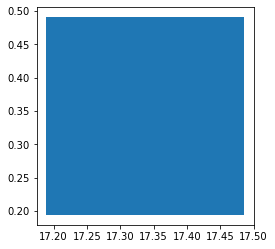

In [14]:
gdf.plot()

In [15]:
gdf.to_file("./inference_output/boundary.geojson", driver="GeoJSON")

In [138]:
window

Window(col_off=0, row_off=0, width=3341, height=3341)

In [128]:
help(get_data_window)

Help on function get_data_window in module rasterio.windows:

get_data_window(arr, nodata=None)
    Window covering the input array's valid data pixels.
    
    Parameters
    ----------
    arr: numpy ndarray, <= 3 dimensions
    nodata: number
        If None, will either return a full window if arr is not a masked
        array, or will use the mask to determine non-nodata pixels.
        If provided, it must be a number within the valid range of the
        dtype of the input array.
    
    Returns
    -------
    Window

